In [1]:
%%bash

#
# Download UniversalDependencies dataset
#

# cf.
# - https://universaldependencies.org/#english-treebanks
# - https://universaldependencies.org/tools.html#conllu

urls=(
    https://github.com/UniversalDependencies/UD_English-GUM/raw/master/en_gum-ud-dev.conllu
    https://github.com/UniversalDependencies/UD_English-GUM/raw/master/en_gum-ud-test.conllu
    https://github.com/UniversalDependencies/UD_English-GUM/raw/master/en_gum-ud-train.conllu
    https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-dev.conllu
    https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-test.conllu    
    https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu
)

outfile=../data/en.conllu

rm -f "$outfile"

for url in "${urls[@]}"; do
    curl -L "$url" >> "$outfile"
    printf '\n' >> "$outfile"
done

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    557      0 --:--:-- --:--:-- --:--:--   559
100 1249k  100 1249k    0     0  1223k      0  0:00:01  0:00:01 --:--:-- 3161k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   165  100   165    0     0    588      0 --:--:-- --:--:-- --:--:--   589
100 1249k  100 1249k    0     0  1153k      0  0:00:01  0:00:01 --:--:-- 2446k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   166  100   166    0     0    319      0 --:--:-- --:--:-- --:--:--   319
100 7935k  100 7935k    0     0  4769k      0  0:00:01  0:00:01 --:--:-- 8486k
  % Total    % Received % Xferd  Average Speed   Tim

In [2]:
#
# Read dataset (annotated sentences)
#

import conllu

outfile = "../data/en.conllu"
dataset = list(conllu.parse_incr(open(outfile)))
len(dataset)

24023

In [3]:
tokens = []
for sentence in dataset:
    for token in sentence:
        tokens.append(token)
len(tokens)

394396

In [4]:
#
# View data with pandas
#
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import functools

In [5]:
df = pd.DataFrame.from_records(tokens)
df[:4]

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc
0,1,Introduction,introduction,NOUN,NN,{'Number': 'Sing'},0.0,root,"[(root, 0)]","{'Discourse': 'preparation:1->29', 'Entity': '..."
1,1,Research,research,NOUN,NN,{'Number': 'Sing'},10.0,nsubj,"[(nsubj, 10)]","{'Discourse': 'background:2->14', 'Entity': '(..."
2,2,on,on,ADP,IN,None,5.0,case,"[(case, 5)]",None
3,3,adult-learned,adult-learned,ADJ,JJ,{'Degree': 'Pos'},5.0,amod,"[(amod, 5)]",{'Entity': '(abstract-3'}


In [6]:
#
# Filter by POS and cleanup 
#

def filter_tokens(df, upos):
    is_upos = df["upos"] == upos
    df = df[is_upos]
    df = df.drop_duplicates(["lemma"])
    is_lower = df.apply(lambda x: x["lemma"].islower() and x["lemma"].isalpha(), axis=1)
    df = df[is_lower]
    return df

df_noun = filter_tokens(df, "NOUN")
df_adj = filter_tokens(df, "ADJ")

print(f"{len(df_noun) = }, {len(df_adj) = }")

len(df_noun) = 7656, len(df_adj) = 2806


In [7]:
def view_dataframe(df, page=0, per=15):
    pd.options.display.max_rows = per
    df = df[page * per:][:per]
    IPython.display.display(df)


def interact_dataframe(df):
    view = functools.partial(view_dataframe, df)
    setattr(view, "__name__", "")
    ipyw.interact(view, page=(0, len(df)), per=(1, 100))


columns = ["lemma", "feats", "misc"]

# Interactively
# interact_dataframe(df_noun[columns])

view_dataframe(df_noun[columns])

,lemma,feats,misc
0,introduction,{'Number': 'Sing'},"{'Discourse': 'preparation:1->29', 'Entity': '..."
1,research,{'Number': 'Sing'},"{'Discourse': 'background:2->14', 'Entity': '(..."
5,language,{'Number': 'Sing'},{'Entity': 'abstract-3)'}
12,insight,{'Number': 'Sing'},None
16,mechanism,{'Number': 'Plur'},None
19,learning,{'Number': 'Sing'},None
21,processing,{'Number': 'Sing'},None
24,grammar,{'Number': 'Sing'},{'Entity': 'abstract-4)abstract-5)abstract-6)a...
34,interest,{'Number': 'Sing'},None
37,study,{'Number': 'Plur'},{'Entity': '(abstract-10)'}


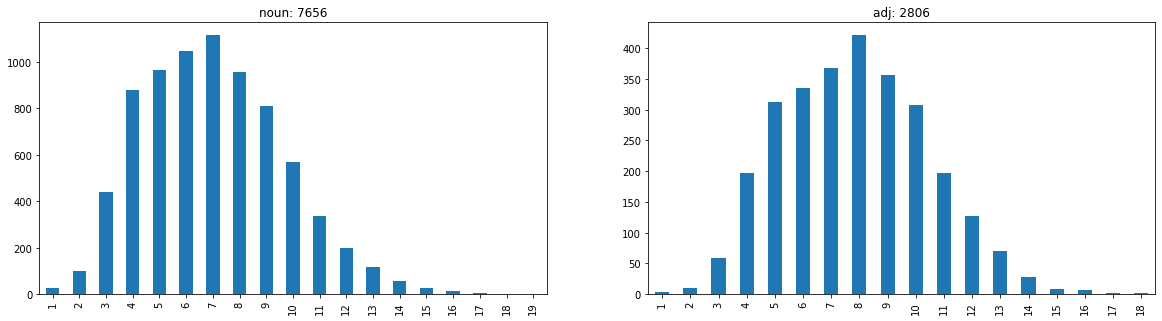

In [8]:
#
# Plot length statistics 
#

def plot(df, **kwargs):
    ds = df.groupby(by=lambda i: len(df["lemma"][i])).size()
    ds.plot(kind="bar", **kwargs)
    

def _():
    fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(20, 5))
    ax0.set(title=f"noun: {len(df_noun)}")
    ax1.set(title=f"adj: {len(df_adj)}")
    plot(df_noun, ax=ax0)
    plot(df_adj, ax=ax1)

_()

In [9]:
#
# Generate random ADJ/NOUN 
#

import random

rand = random.SystemRandom()

adjs = sorted(list(df_adj["lemma"]))
nouns = sorted(list(df_noun["lemma"]))

print(len(adjs), len(nouns))
print(len("".join(adjs)), len("".join(nouns)))


adjs2 = list(filter(lambda x: len(x) <= 6, adjs))
nouns2 = list(filter(lambda x: len(x) <= 6, nouns))

print(len(adjs2), len(nouns2))


def generate(adjs, nouns):
    adj = rand.sample(adjs, 2)
    noun = rand.sample(nouns, 1)
    return " ".join(adj + noun)


generate(adjs2, nouns2)

2806 7656
22019 53640
917 3458


'frothy right colony'

In [10]:
def flatten(xss):
    ys = []
    for xs in xss:
        for x in xs:
            ys.append(x)
    return ys


def generate_password(adjs, nouns):
    adj = rand.sample(adjs, 2)
    noun = rand.sample(nouns, 1)
    words = map(str.capitalize, adj + noun)
    nums = map(str, rand.sample(range(10), 3))
    result = "".join(flatten(zip(words, nums)))
    return result


generate_password(adjs2, nouns2)

'Sr1Aged3Prs4'

In [11]:
#
# Export adj.txt and noun.txt
#

open("../data/adj.txt", "w").write("\n".join(adjs))
open("../data/noun.txt", "w").write("\n".join(nouns))

61295